# Import Packages and Construct Bitome

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mode
import seaborn as sns
from sklearn.metrics import median_absolute_error
from tqdm.notebook import tqdm

sys.path.append('../../bitome2')

from bitome.core import Bitome
from bitome.util import create_motif

In [2]:
K12_DATA_PATH = Path('../data/bitome2/mg1655')

In [3]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

In [4]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

## Profile Intergenic Spaces within TUs

In [5]:
intra_tu_spaces = []
for tu_id, tu_gene_ids in mg1655._tu_to_genes.items():
    if len(tu_gene_ids) > 1:
        tu_gene_df = mg1655.gene_table.loc[tu_gene_ids]
        tu_row = mg1655.tu_table.loc[tu_id]
        sorted_gene_df = tu_gene_df.sort_values(by='left')
        for gene_row_l, gene_row_r in zip(
            sorted_gene_df.iloc[:-1].itertuples(), sorted_gene_df.iloc[1:].itertuples()
        ):
            intra_tu_space = max(gene_row_r.left - gene_row_l.right, 0)
            intra_tu_spaces.append(intra_tu_space)

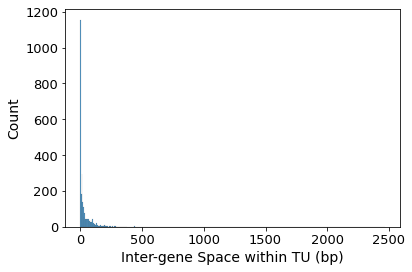

In [6]:
_, ax = plt.subplots()
sns.histplot(intra_tu_spaces)
ax.set_xlabel('Inter-gene Space within TU (bp)', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(axis='both', labelsize=13)

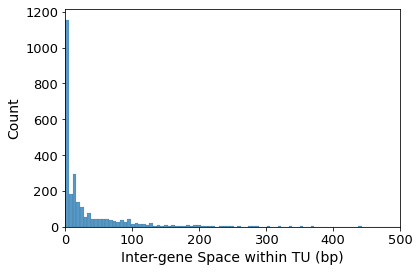

In [7]:
_, ax = plt.subplots()
sns.histplot(intra_tu_spaces)
ax.set_xlim(0, 500)
ax.set_xlabel('Inter-gene Space within TU (bp)', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(axis='both', labelsize=13)

So the majority of these spaces are under 200 bp; sometimes genes even overlap (i.e. astCADBE)

## Profile 5' UTRs

In [8]:
utr_lens = []
for tu_row in mg1655.tu_table.itertuples():
    if pd.notna(tu_row.tss):
        tu_gene_df = mg1655.gene_table.loc[mg1655._tu_to_genes[tu_row.Index]]
        if not tu_gene_df.empty:
            if tu_row.strand == 1:
                first_gene_start = tu_gene_df.sort_values(by='left').iloc[0, :]['left']
            else:
                first_gene_start = tu_gene_df.sort_values(by='right', ascending=False).iloc[0, :]['right']
            utr_len = abs(tu_row.tss - first_gene_start)
            utr_lens.append(utr_len)

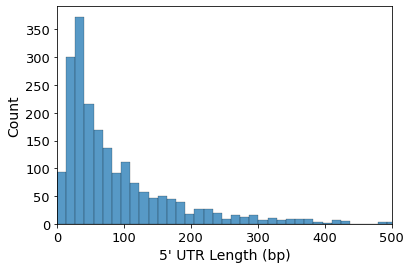

In [9]:
_, ax = plt.subplots()
sns.histplot(utr_lens)
ax.set_xlim(0, 500)
ax.set_xlabel("5' UTR Length (bp)", fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(axis='both', labelsize=13)

So most of these are also under 200

## TSS within Gene

How often do we have a TSS within a gene?

In [10]:
tss_in_gene_count = 0
for tu_row in mg1655.tu_table.itertuples():
    if pd.notna(tu_row.tss):
        gene_in_tss = mg1655.gene_table[
            (mg1655.gene_table['left'] < tu_row.tss) & 
            (mg1655.gene_table['right'] > tu_row.tss) & 
            (mg1655.gene_table['strand'] == tu_row.strand)
        ]
        tss_in_gene_count += gene_in_tss.shape[0]

print(f'{tss_in_gene_count} cases of TSS located within gene on same strand')

276 cases of TSS located within gene on same strand


Okay so that's enough for us to not be able to really ignore these

# -10/-35 Based Motif Finding

  0%|          | 0/3542 [00:00<?, ?it/s]

left                 1830762
right                1831982
strand                    -1
pseudo                 False
name                    astC
cog                        E
essential                NaN
y-ome         well-annotated
tpm                  10.6386
tpm_ctrl             15.6907
tpm_all              6.77529
reg_effect         activated
log_tpm              3.54084
Name: b1748, dtype: object 

b10 1832022.0
b35 1832047.0
left                 1830762
right                1831982
strand                    -1
pseudo                 False
name                    astC
cog                        E
essential                NaN
y-ome         well-annotated
tpm                  10.6386
tpm_ctrl             15.6907
tpm_all              6.77529
reg_effect         activated
log_tpm              3.54084
Name: b1748, dtype: object 

b10 1832054.0
b35 1832065.0
left                 1830762
right                1831982
strand                    -1
pseudo                 False
name            

KeyError: 4035239.0

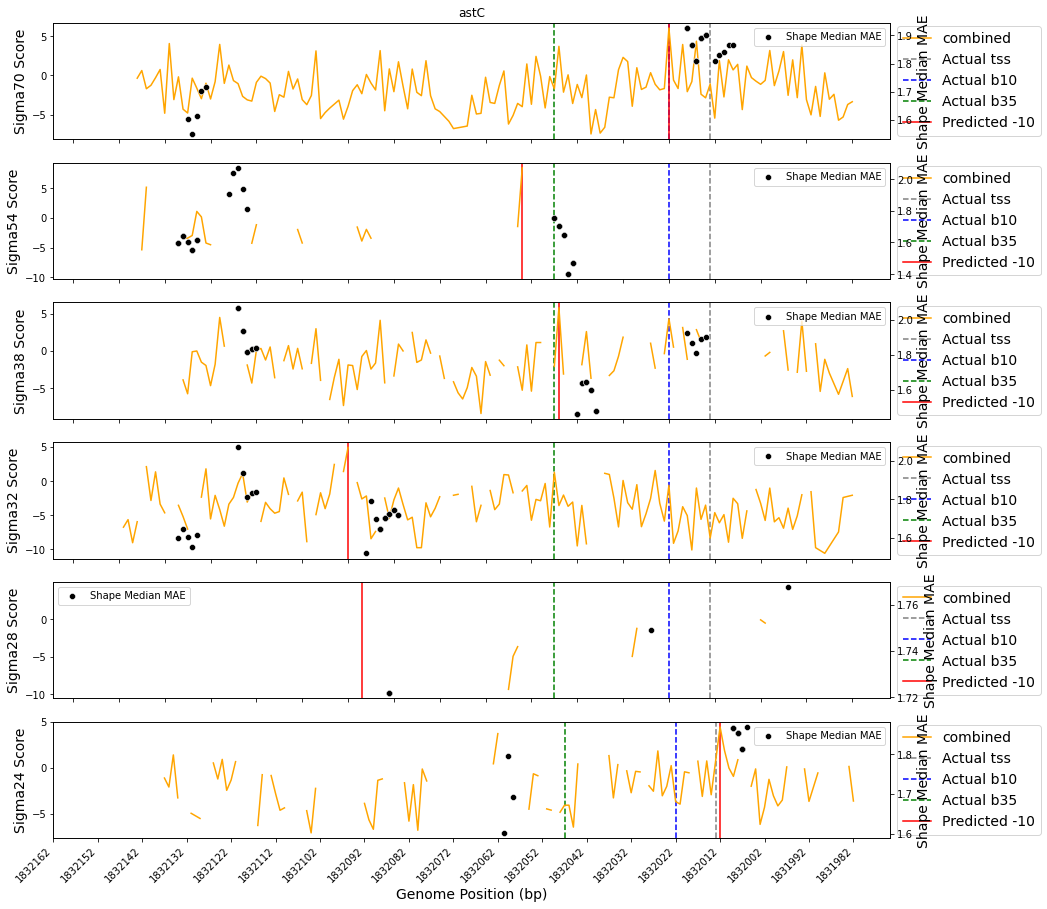

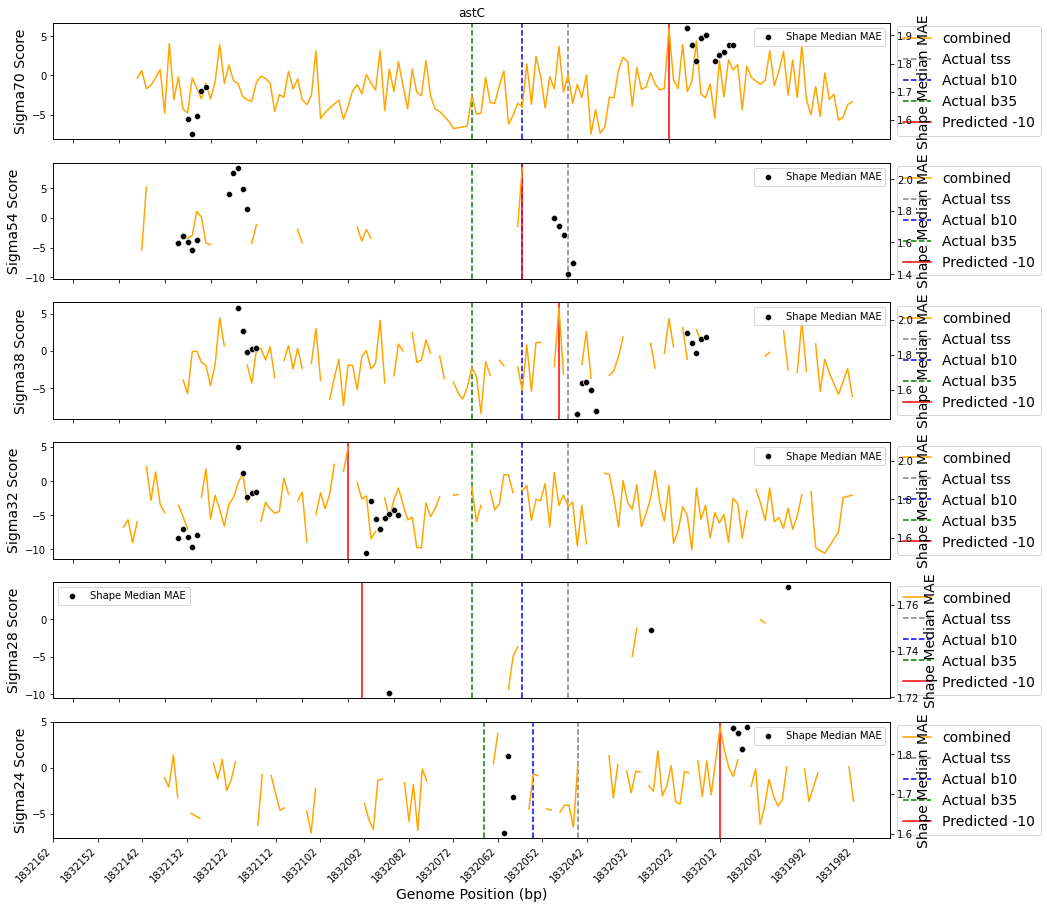

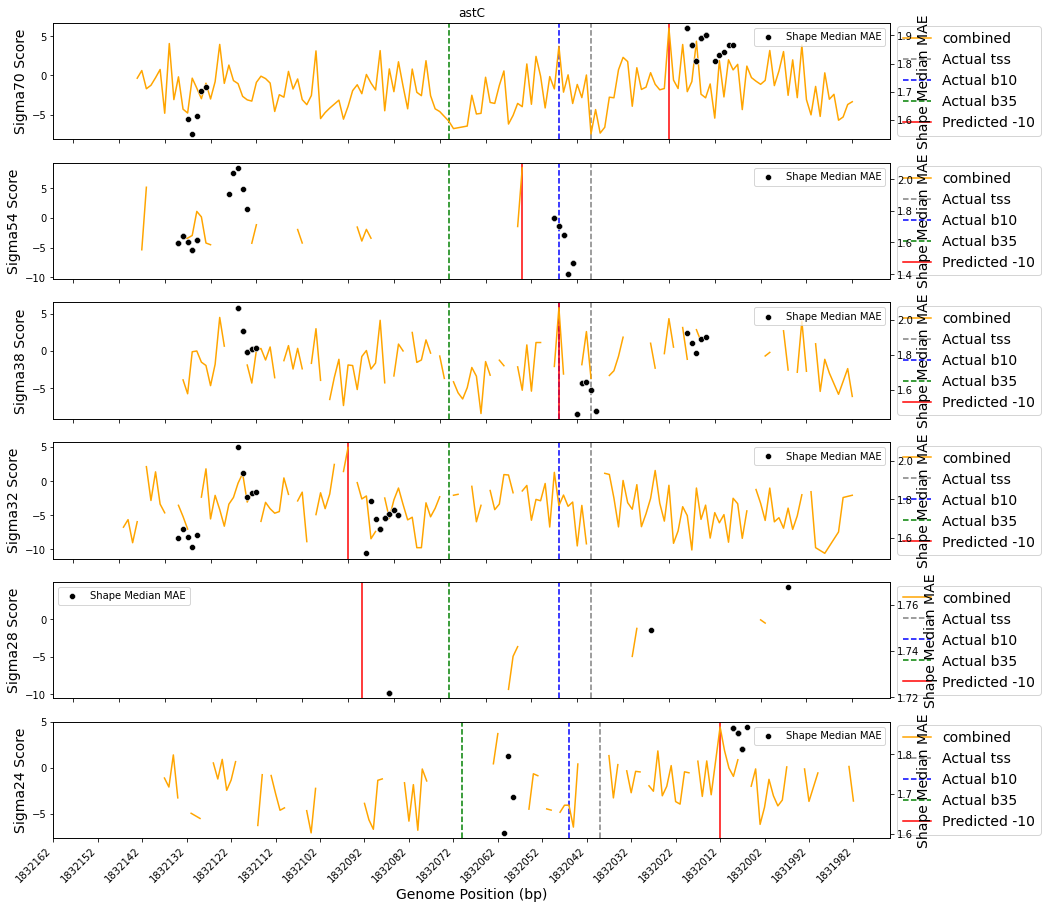

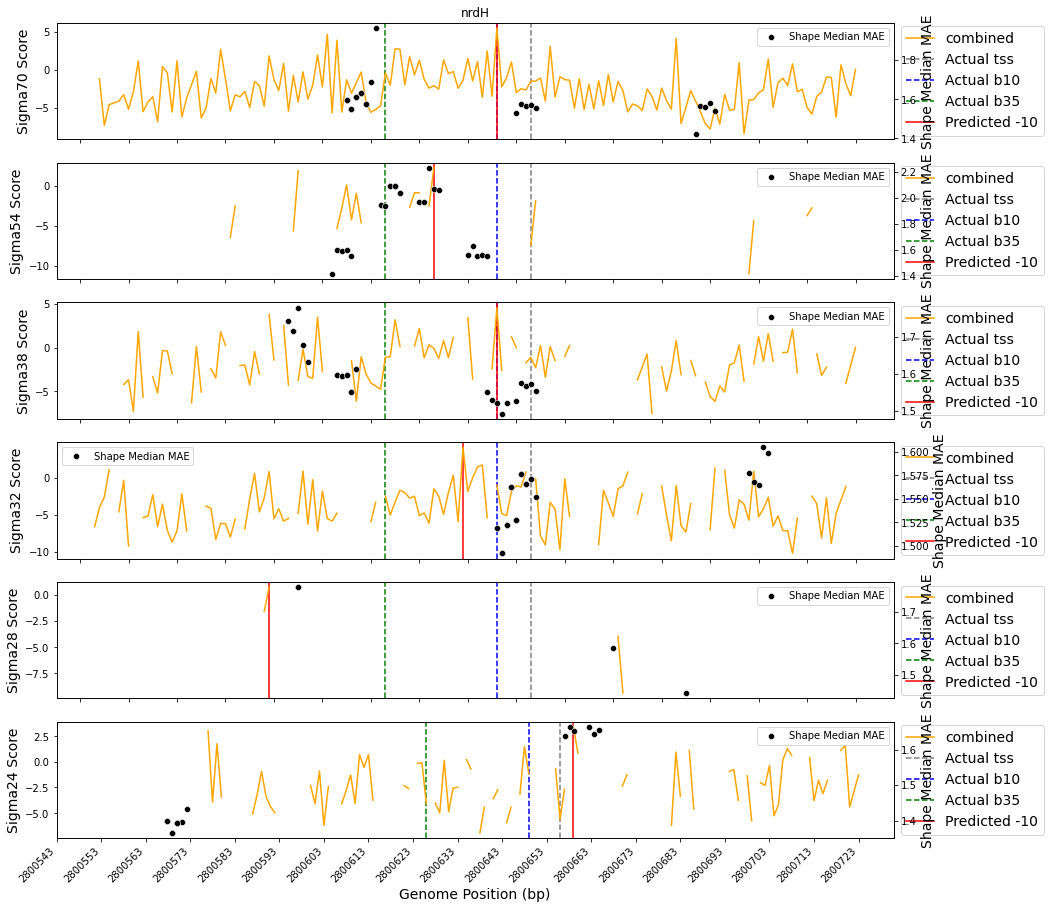

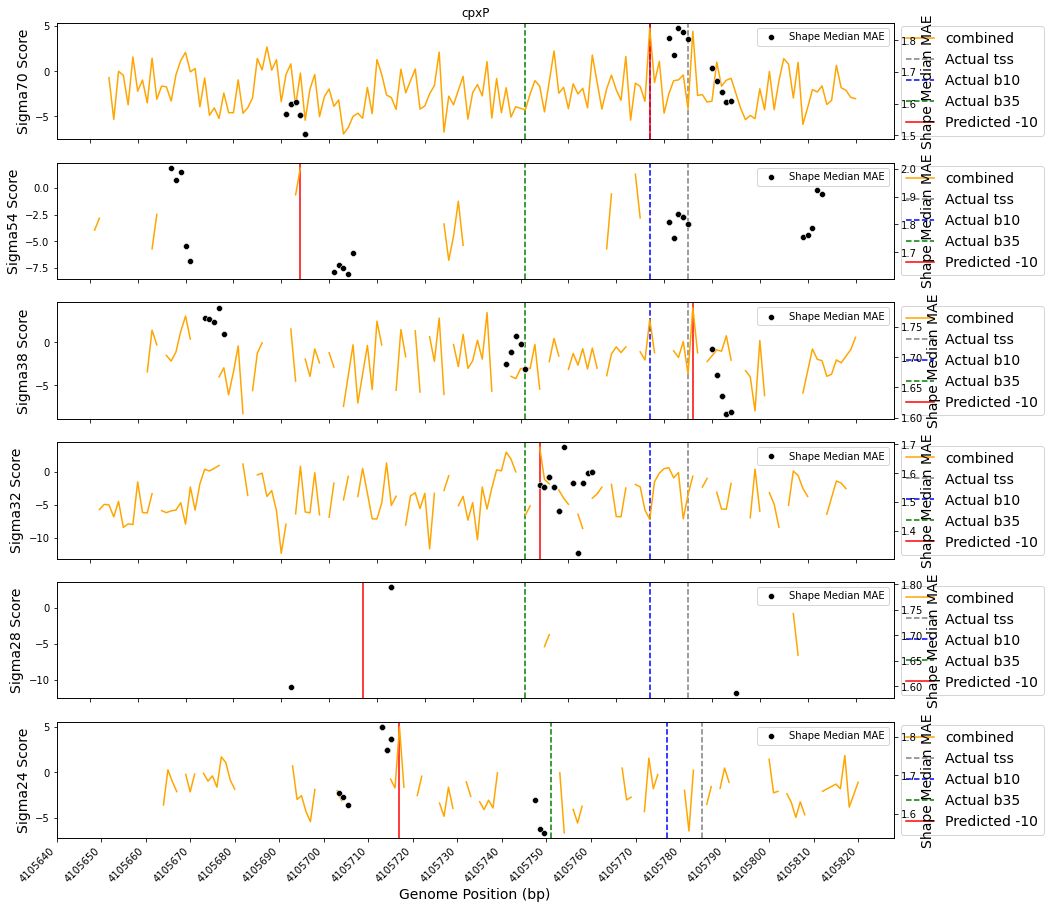

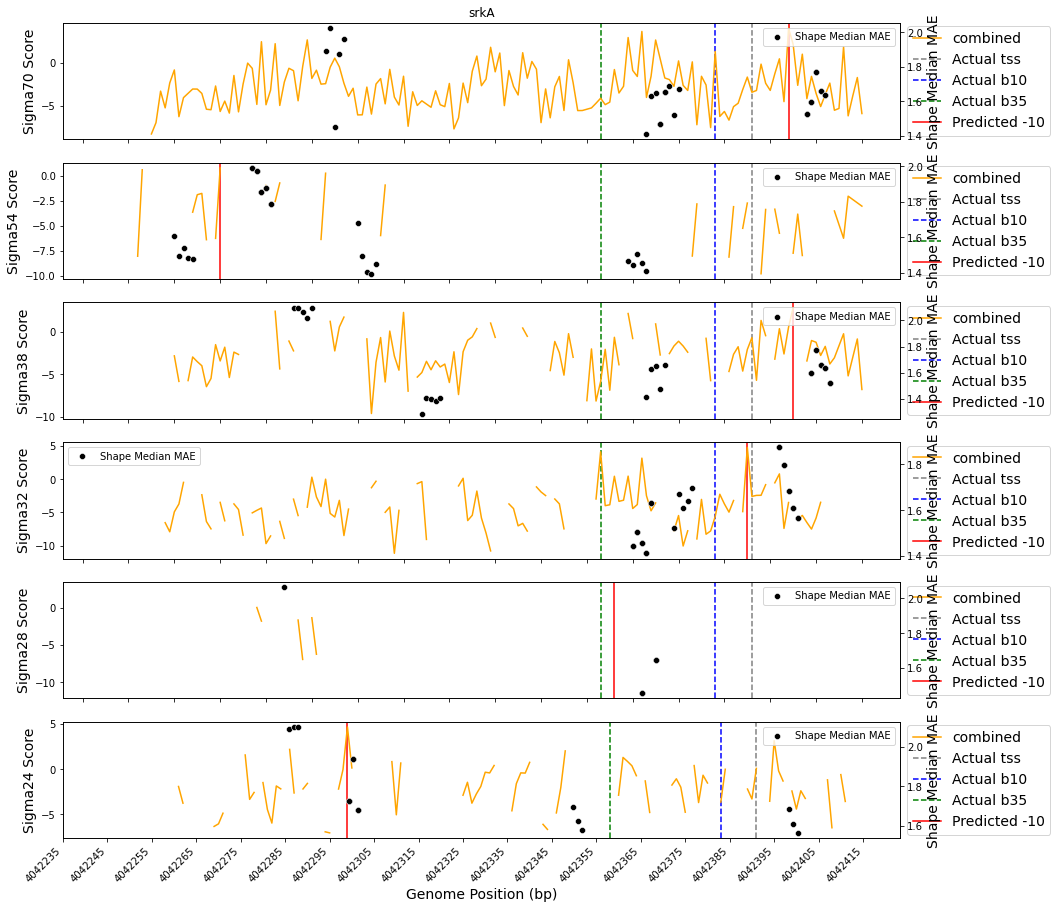

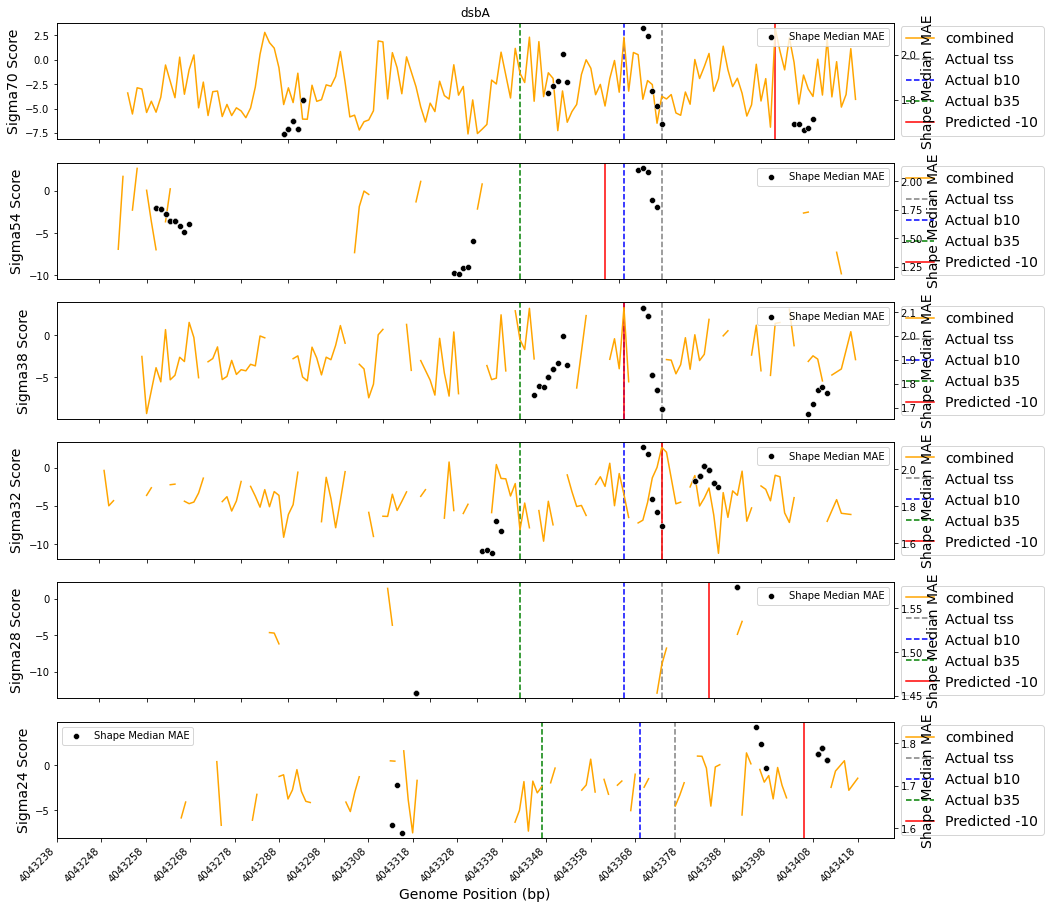

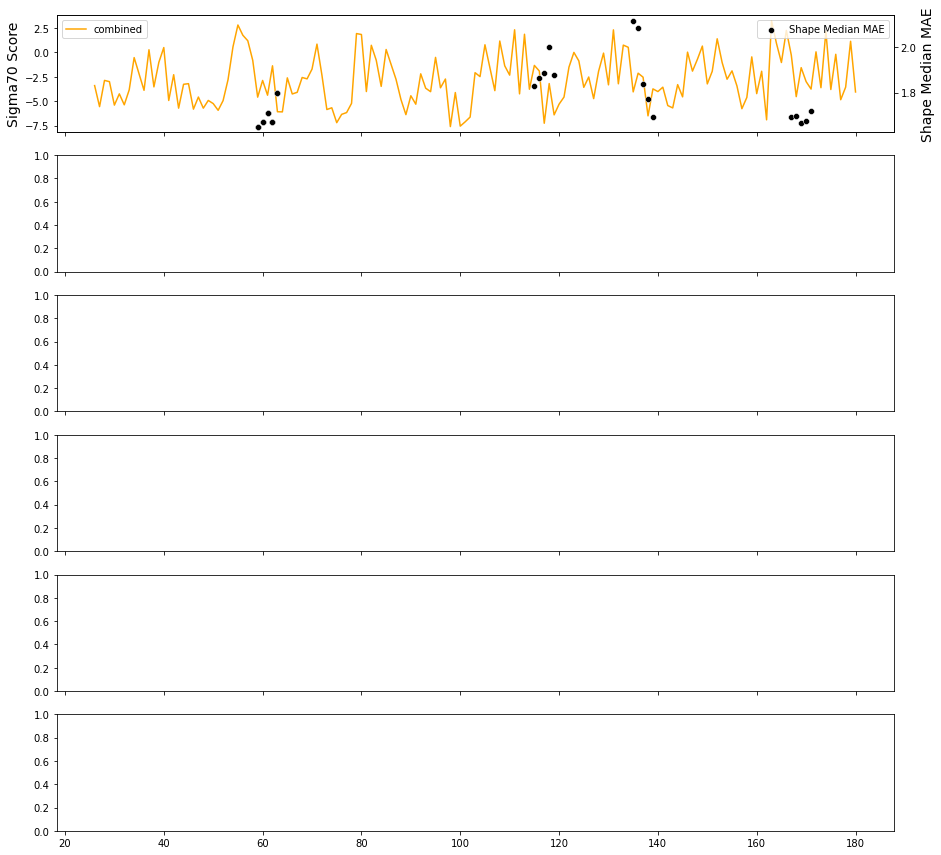

In [16]:
result_rows = []
for i, tu_row in tqdm(list(enumerate(mg1655.tu_table.itertuples()))):
    if pd.notna(tu_row.tss) and pd.notna(tu_row.sigma_factor) and \
        pd.notna(tu_row.box_10_left) and pd.notna(tu_row.box_35_left) :

        tu_genes = mg1655._tu_to_genes[tu_row.Index]
        tu_gene_df = mg1655.gene_table.loc[tu_genes]
        if not tu_gene_df.empty :
            strand = tu_row.strand
            if (strand == 1) and pd.notna(tu_gene_df.sort_values(by='left').iloc[0].tpm):
                first_gene_row = tu_gene_df.sort_values(by='left').iloc[0]
            elif (strand == -1) and pd.notna(tu_gene_df.sort_values(by='right').iloc[0].tpm):
                first_gene_row = tu_gene_df.sort_values(by='right', ascending=False).iloc[0]

            print(first_gene_row, '\n')
            b10_down = tu_row.box_10_right if strand == 1 else tu_row.box_10_left
            b35_down = tu_row.box_35_right if strand == 1 else tu_row.box_35_left
            
            print('b10', b10_down)
            print('b35', b35_down)
            
            actual_info_dict = {
                'tss': [tu_row.tss],
                'b10': [b10_down],
                'b35': [b35_down]
            }
            actual_sigma_b10 = {}
            sigmas = [s.strip() for s in tu_row.sigma_factor.split(',')]
            for sigma in sigmas:
                actual_sigma_b10[sigma] = b10_down

            b10_down_pred_dict = mg1655.predict_tss(
                first_gene_row,
                n_upstream=180,
                true_tss_data=actual_info_dict,
                plot=True
            )

            for sigma, actual_b10_down in actual_sigma_b10.items():
                row_dict = {
                    'tu_id': tu_row.Index,
                    'gene_id': first_gene_row.name,
                    'gene_name': first_gene_row['name'],
                    'sigma': sigma,
                    'actual_b10': actual_b10_down,
                    'predicted_b10': b10_down_pred_dict[0][sigma]
                }
                result_rows.append(row_dict)
                
    if i > 20:
        break

result_df = pd.DataFrame(result_rows)
result_df

In [ ]:
%load_ext rpy2.ipython

In [ ]:
# %%R
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install(version = "3.9")
# BiocManager::install("DNAshapeR")

result_df.to_csv('../data/tu_finder_v0_result.csv')

In [ ]:
%%R
library('DNAshapeR')

In [ ]:
%%R

installed.packages()

## Notes

- Look at failure cases
- Compare against different ground truth (BK's data)
- Add shape to distinguish best choices based on motif
- Maybe use actual ML if scan results can be translated into feature
    - automated way to use thresholding
    - Can penalize spacers?
    - Does spacer bending/properties matter?

## Plot Results

In [ ]:
correct_predictions = result_df[result_df['predicted_b10'] == result_df['actual_b10']]
incorrect_predictions = result_df[result_df['predicted_b10'] != result_df['actual_b10']]

print(f'# of Total TUs: {result_df.shape[0]}')
print(f'# of Correct Predictions: {correct_predictions.shape[0]}')
print(f'Accuracy: {correct_predictions.shape[0]/result_df.shape[0]*100:.1f}%')

In [ ]:
_, ax = plt.subplots(figsize=(7, 5))

xticks = []
sigmas = []
for i, (sigma, sigma_df) in enumerate(result_df.groupby('sigma')):
    n_correct = sigma_df[sigma_df['predicted_b10'] == sigma_df['actual_b10']].shape[0]
    n_wrong = sigma_df[sigma_df['predicted_b10'] != sigma_df['actual_b10']].shape[0]
    acc = np.round((n_correct/(n_correct + n_wrong)) * 100, decimals=0)
    ax.bar(i*2-0.4, n_wrong, color='red', label='wrong', width=0.75)
    ax.bar(i*2+0.4, n_correct, color='green', label='correct', width=0.75)
    ax.text(i*2, max(n_wrong, n_correct), f'{acc}%', fontsize=14, ha='center', va='bottom')
    sigmas.append(sigma)
    xticks.append(i*2)

ax.set_xticks(xticks)
ax.set_xticklabels(sigmas)
ax.tick_params(axis='both', labelsize=13)
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], fontsize=14)

In [ ]:
off_dists = result_df['actual_b10'] - result_df['predicted_b10']
outside_search = off_dists[off_dists.abs() > 100]
inside_search = off_dists[off_dists.abs() <= 100]

_, ax = plt.subplots()
sns.histplot(inside_search, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('Prediction Error (bp)', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title(f'n={inside_search.shape[0]} ({outside_search.shape[0]} outside search range)')

# Promoter Shape

In [ ]:
%%R

library("DNAshapeR")

shape_names_all = c('HelT', 'Rise', 'Roll', 'Shift', 'Slide', 'Tilt', 'MGW', 'Buckle', 'Opening', 'ProT', 'Shear', 'Stagger', 'Stretch', 'EP')
getShape(
  "/mnt/d/Strainware-s/bitome2/bitome/shape_work_dir/shape_tmp/shape_seqs.fa",
  shapeType = shape_names_all,
  parse = FALSE
)

## z-scoring in Search Range

Since the shape features have very different value ranges, we need to normalize (z-score) them so that we can treat them equally when comparing the reference shapes to a putative promoter region's shape. To do this, we need to get sample means and SDs for the regions in which we plan to search. 

So let's get shape for that second set of regions now

We're not interested in base pair-specific variation, just the overall dynamic ranges of the shape features in these regions

In [ ]:
shape_z_score_df = mg1655.tss_reference_shape()
shape_z_score_df

In [ ]:
%%R

library("DNAshapeR")

shape_names_all = c('HelT', 'Rise', 'Roll', 'Shift', 'Slide', 'Tilt', 'MGW', 'Buckle', 'Opening', 'ProT', 'Shear', 'Stagger', 'Stretch', 'EP')

getShape(
  "/mnt/d/Strainware-s/bitome2/bitome/shape_work_dir/shape_tmp/shape_seqs.fa",
  shapeType = shape_names_all,
  parse = FALSE
)

In [ ]:
import subprocess
subprocess.check_output(['Rscript', str(Path(shape_work_dir, 'compute_shape.R'))])

## Define TSS Region Ground Truth

In [ ]:
N_UP_TSS_SHAPE = 15
N_DOWN_TSS_SHAPE = 5

In [ ]:
tss_shape_reference_df, combined_tss_shape_df = mg1655.tss_reference_shape(
    n_upstream=N_UP_TSS_SHAPE, n_downstream=N_DOWN_TSS_SHAPE,
    z_score_stat_df=shape_z_score_df, return_raw=True
)
tss_shape_reference_df.head()

## Compute Random Shape for Comparison

In [ ]:
random_rows_for_shape = []

idxes = [
    str(num) for num in range(int(combined_tss_shape_df.shape[0] / (N_UP_TSS_SHAPE + N_DOWN_TSS_SHAPE + 1)))
]

for idx in idxes:
    
    random_tss = np.random.choice(np.arange(100, len(mg1655.sequence) - 100))
    random_strand = np.random.choice([-1, 1])
    if random_strand == 1:
        l, r = random_tss - N_UP_TSS_SHAPE, random_tss + N_DOWN_TSS_SHAPE
    else:
        l, r = random_tss - N_DOWN_TSS_SHAPE, random_tss + N_UP_TSS_SHAPE
    random_rows_for_shape.append({
        'left': l,
        'right': r,
        'strand': random_strand
    })
    
random_to_get_shape_df = pd.DataFrame(random_rows_for_shape, index=idxes)

random_shape_df_dict = mg1655.get_dna_shape(random_to_get_shape_df)

for random_id, random_shape_df in random_shape_df_dict.items():
    random_shape_df['bp'] = np.arange(-N_UP_TSS_SHAPE, N_DOWN_TSS_SHAPE + 1)

# make the mega shape DF
combined_random_tss_shape_df = pd.concat(list(random_shape_df_dict.values()))

## Shape Distributions

### TSS

In [ ]:
_, axs = plt.subplots(3, 5, figsize=(12, 8))
axs = axs.flatten()

for shape_col, ax in zip(combined_tss_shape_df.columns, axs):
    
    sns.histplot(x=shape_col, data=combined_tss_shape_df, ax=ax)
    ax.set_xlabel(shape_col, fontsize=12)
    ax.tick_params(axis='both', labelsize=11)
    
axs[-1].set_visible(False)
plt.tight_layout()

### Random

In [ ]:
_, axs = plt.subplots(3, 5, figsize=(12, 8))
axs = axs.flatten()

for shape_col, ax in zip(combined_random_tss_shape_df.columns, axs):
    
    sns.histplot(x=shape_col, data=combined_random_tss_shape_df, ax=ax)
    ax.set_xlabel(shape_col, fontsize=12)
    ax.tick_params(axis='both', labelsize=11)
    
axs[-1].set_visible(False)
plt.tight_layout()

## Plot Shape in Region

In [ ]:
for shape_col in combined_tss_shape_df.columns:
    
    _, ax = plt.subplots(figsize=(12, 4))
    sns.lineplot(x='bp', y=shape_col, data=combined_tss_shape_df, color='blue', label='TSS', ax=ax)
    sns.lineplot(x='bp', y=shape_col, data=combined_random_tss_shape_df, color='gray', label='Random', ax=ax)
    ax.set_ylabel(shape_col, fontsize=14)
    ax.tick_params(axis='both', labelsize=13)

# Shape-Based Finding

In [ ]:
tu_both_box_sigma_df.iloc[:50]

In [ ]:
# use some of the first TUs as manual test cases
SHAPE_TEST_CASES = {
    'b1748': [1832013, 1832044, 1832039], #astC
    'b2673': [2800656], #nrdH
    'b4484': [4105785], #cpxP
    'b3859': [4042391], # srkA
    'b3860': [4043377], # dsbA
    'b1761': [1842308], # gdhA
    'b4224': [4448428], # chpS
    'b1597': [1671327], # asr
    'b2980': [3128206], # glcC
    'b2979': [3128076], # glcD
}

TEST_SEARCH_RANGE = 200

for test_gene, test_actual_tsses in SHAPE_TEST_CASES.items():

    gene_row = mg1655.gene_table.loc[test_gene]
    gene_strand = gene_row.strand
    if gene_strand == 1:
        search_l, search_r = gene_row.left - TEST_SEARCH_RANGE, gene_row.left
    else:
        search_l, search_r = gene_row.right, gene_row.right + TEST_SEARCH_RANGE
    search_df = pd.DataFrame(
        data={'left': search_l, 'right': search_r, 'strand': gene_row.strand},
        index=[test_gene]
    )

    # get the shape in this region
    search_shape_df = mg1655.get_dna_shape(search_df)[test_gene]
    search_shape_df['Roll'] = search_shape_df['Roll'].copy().abs()
    # z-score the shape using our mean/SD from earlier
    for shape_col in search_shape_df.columns:
        mean, std = shape_z_score_df.loc[shape_col, ['mean', 'std']]
        search_shape_df[shape_col] = (search_shape_df[shape_col].copy() - mean) / std

    # for each possible TSS in the shape data, compare to the reference
    putative_tsses = np.array(search_shape_df.index)[
        np.arange(N_UP_TSS_SHAPE, search_shape_df.shape[0] - N_DOWN_TSS_SHAPE)
    ]
    shape_mae_dicts = []
    for putative_tss in putative_tsses:

        # get the putative shape DF
        if gene_strand == 1:
            putative_range = np.arange(putative_tss - N_UP_TSS_SHAPE, putative_tss + N_DOWN_TSS_SHAPE + 1)
        else:
            putative_range = np.flip(np.arange(putative_tss - N_DOWN_TSS_SHAPE, putative_tss + N_UP_TSS_SHAPE + 1))
        putative_tss_shape_df = search_shape_df.loc[putative_range]

        # compare the z-scored shapes of the ground truth and this putative range
        shape_mae_dict = {}
        for shape_col in tss_shape_reference_df.columns:
            true_col = tss_shape_reference_df[shape_col]
            putative_col = putative_tss_shape_df[shape_col]
            mae = median_absolute_error(true_col, putative_col)
            shape_mae_dict[shape_col] = mae
        shape_mae_dicts.append(shape_mae_dict)
    
    # set up the results to plot; we want to see if the shapes in aggregate, OR the individual shapes,
    # can be helpful at all for TSS finding
    shape_mae_df = pd.DataFrame(shape_mae_dicts, index=putative_tsses)
    shape_mae_df['median'] = shape_mae_df.median(axis=1)
    
    # plot each of the score profiles
    _, axs = plt.subplots(len(shape_mae_df.columns), 1, figsize=(15, 25), sharex=True)
    for shape_col, ax in zip(shape_mae_df.columns, axs):
        ax.plot(np.arange(len(putative_tsses)), shape_mae_df[shape_col])
        ax.set_ylabel(f'{shape_col} MAE', fontsize=14)
        ax.tick_params(axis='both', labelsize=12)
        for actual_tss in test_actual_tsses:
            ax.axvline(np.argwhere(putative_tsses == actual_tss), color='red')
    axs[0].set_title(f"{gene_row['name']}", fontsize=15)
    axs[-1].set_xticks(np.arange(0, len(putative_tsses), 10))
    axs[-1].set_xticklabels([tss for i, tss in enumerate(putative_tsses) if i % 10 == 0], rotation=45, ha='right')
    axs[-1].set_xlabel('TSS location', fontsize=14)